<a href="https://colab.research.google.com/github/KeisukeShimokawa/papers-challenge/blob/master/src/gan/CRGAN/notebooks/SimCLR_Augmentation_in_Kornia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -q https://www.pakutaso.com/shared/img/thumb/AMEMAN17826009_TP_V.jpg -O dog.jpg
!wget -q https://www.pakutaso.com/shared/img/thumb/nekocyan458A5348_TP_V.jpg -O cat.jpg

!ls

cat.jpg  dog.jpg  sample_data


In [2]:
!pip install kornia

     |████████████████████████████████| 163kB 2.7MB/s 


## SimCLR

```python
RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(3./4., 4./3.)),
RandomHorizontalFlip(p=0.5),
ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s),
RandomGrayscale(p=0.2),
GaussianBlur(k=0.1*size, sigma)
```

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

from kornia.filters import GaussianBlur2d
from kornia.augmentation import (
    RandomResizedCrop,
    RandomHorizontalFlip,
    ColorJitter,
    RandomGrayscale
)

In [4]:
class KorniaCompose:

    def __init__(self, tensor_transforms):
        self.tensor_transforms = tensor_transforms

    def __call__(self, img_tensor):

        for tensor_t in self.tensor_transforms:
            img_tensor = tensor_t(img_tensor)

        return img_tensor

In [5]:
input_shape = (256, 256, 3)
sigma = (2.0 - 0.1)*np.random.random_sample() + 0.1

In [6]:
simclr_aug = KorniaCompose([
    RandomResizedCrop(size=input_shape[:2], scale=(0.08, 1.0)),
    RandomHorizontalFlip(p=0.5),
    ColorJitter(0.8, 0.8, 0.8, 0.2),
    RandomGrayscale(p=0.2),
    GaussianBlur2d(kernel_size=tuple(map(lambda x: int(x*0.1), input_shape[:2])), 
                   sigma=(sigma, sigma))
])

## Test

In [7]:
img_tensor = []
for fname in ["cat.jpg", "dog.jpg"]:
    img_tensor.append(ToTensor()(Image.open(fname).resize(input_shape[:2])).unsqueeze(0))

img_tensor = torch.cat(img_tensor, dim=0)
print(img_tensor.shape)

torch.Size([2, 3, 256, 256])


In [8]:
def plot_tensor(img_tensor):
    # craete grid_tensor for plot
    img_tensor = make_grid(img_tensor, nrow=8)
    # normalize pixel value [0, 1]
    min_val = float(img_tensor.min())
    max_val = float(img_tensor.max())
    img_tensor.clamp_(min=min_val, max=max_val)
    img_tensor.sub_(min_val).div_(max_val - min_val + 1e-5)
    # convert torch.Tensor to ndarray
    img_tensor = img_tensor.cpu().permute(1, 2, 0).numpy()

    plt.imshow(img_tensor)
    plt.show()

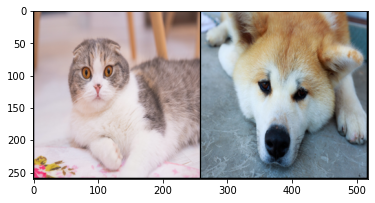

In [9]:
plot_tensor(img_tensor)

In [10]:
img_tensor.min(), img_tensor.max()

(tensor(0.), tensor(1.))

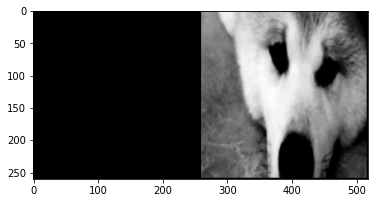

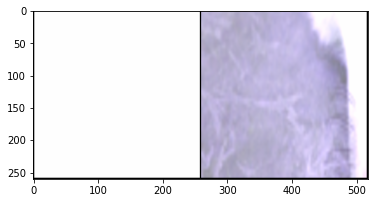

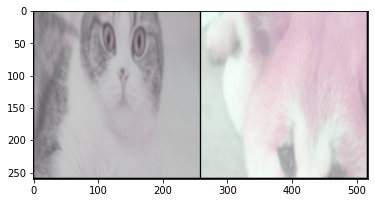

In [11]:
for _ in range(3):
    plot_tensor(simclr_aug(img_tensor))

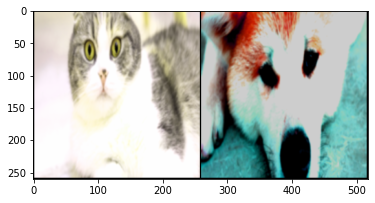

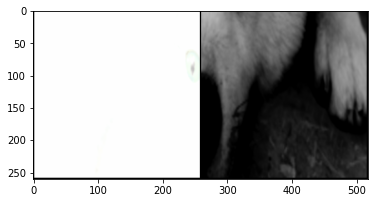

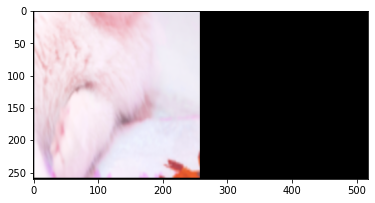

In [12]:
# CUDA
for _ in range(3):
    plot_tensor(simclr_aug(img_tensor.to("cuda:0")))